# Machine Learning Pipeline - Evaluación de Nuevos Datos

Imaginemos que un colega del departamento de negocios se acerca y nos solicita evaluar los datos de los clientes del mes pasado. Quieren asegurarse de que nuestro modelo está funcionando correctamente con los datos más recientes que tiene la organización.

**¿Cómo procederías para evaluar los nuevos datos?** Inténtalo. Hay más de una forma de hacerlo.

A continuación, presentamos una posible solución.

¿Qué podríamos haber hecho mejor?

In [60]:
from feature_engine.imputation import MeanMedianImputer


In [1]:
# to handle datasets
import pandas as pd
import numpy as np

# for plotting
import matplotlib.pyplot as plt

# for the yeo-johnson transformation
import scipy.stats as stats

# to save the model
import joblib

In [6]:
# load the unseen / new dataset
data = pd.read_parquet('../data/test.parquet')

# rows and columns of the data
print(data.shape)

# visualise the dataset
data.head()

(90000, 71)


,DNI,BASE,CELULAR1,CELULAR2,CELULAR3,12M_MONTO,12M_TASA,18M_MONTO,18M_TASA,24M_MONTO,...,dias_ultima_gestion,ultima_gestion,veces_sin_respuesta,veces_solicitud_seguimiento,promedio_dias_entre_gestiones,max_intentos_en_un_mes,veces_respuesta_positiva,veces_respuesta_negativa,_merge_variables,target
0,0,2025_01,944256646,941892836,None,7400.0,0.799,8700.0,0.799,8700.0,...,NaN,NO GESTIONADO,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
1,1,2025_01,952918805,952918808,967905361,9900.0,0.780,13100.0,0.780,15500.0,...,1.0,NO CONTACTO,228.0,0.0,0.0,240.0,0.0,12.0,1.0,0.0
2,2,2025_01,954651500,954651840,None,6900.0,0.650,9300.0,0.650,11200.0,...,0.0,CONTACTO NO EFECTIVO,31.0,0.0,0.0,41.0,0.0,10.0,1.0,0.0
3,3,2025_01,986354919,942159204,None,4000.0,0.650,5400.0,0.650,6500.0,...,NaN,NO GESTIONADO,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
4,4,2025_01,None,None,None,4200.0,0.799,5500.0,0.799,5500.0,...,5.0,CONTACTO NO EFECTIVO,59.0,0.0,0.0,55.0,0.0,6.0,1.0,0.0


# Cargando Preprocesamiento de Datos

In [30]:
valores_permitidos_cats = {'ULTIMA_AGRUPACION': ['CONTACTO NO EFECTIVO',
  None,
  'NO CONTACTO',
  'NO CONTACTO MAQUINA',
  'CONTACTO EFECTIVO'],
 'GENERO': ['M', 'F', None],
 'COMPETITIVIDAD': ['OFERTA MAYOR A ALGUNA DEUDA', None],
 'PRINCIPALIDAD_CONSUMO': ['DEUDA EN BANCOS GRANDES',
  'SIN DEUDA CONSUMO',
  'DEUDA EN BANCOS MEDIANOS',
  'DEUDA EN CAJAS'],
 'MARCA_LABORAL': ['3.INDEPENDIENTE',
  '2.DEPEN+INDEPEN',
  '1.DEPENDIENTE',
  '4.INFORMAL'],
 'PROPENSION': ['PROPENSION 1', 'PROPENSION 2'],
 'LIMAS': ['LIMA CENTRO',
  'FUERA DE LIMA',
  'LIMA OESTE',
  'LIMA NORTE',
  'LIMA ESTE',
  'LIMA SUR',
  'CALLAO'],
 'MENSAJE_VARIACION': ['MISMA OFERTA Y MAS TASA',
  'CON MAS OFERTA Y MISMA TASA',
  'CON MAS OFERTA Y MAS TASA',
  'CON MAS OFERTA',
  'MISMA OFERTA',
  'MISMA OFERTA Y MENOS TASA',
  'MISMA OFERTA Y MISMA TASA',
  'NUEVA OFERTA',
  'MENOS OFERTA Y MAS TASA',
  'MENOS OFERTA Y MISMA TASA',
  'CON MAS OFERTA Y MENOS TASA',
  'MENOS OFERTA Y MENOS TASA'],
 'RANGO_RCI': ['3. [20%,30%>',
  '1. <0%,10%>',
  '4. [30%,60%]',
  '2. [10%,20%>',
  '0. SIN DEUDA'],
 'ESTADO_CIVIL': ['Soltero', 'Casado', 'Otro'],
 'ultima_gestion': ['NO GESTIONADO',
  'NO CONTACTO',
  'CONTACTO NO EFECTIVO',
  'CONTACTO EFECTIVO']}

bancos_comerciales_pld = ["PLD_BCP", "PLD_BBVA", "PLD_SCOTIA", "PLD_INTERBANK", "PLD_PICHINCHA", "PLD_NACION"]
bancos_comerciales_tc = ["TC_BCP", "TC_BBVA", "TC_SCOTIA", "TC_INTERBANK", "TC_PICHINCHA"]

cajas_ahorro_pld = ["PLD_C_HUANCAYO", "PLD_C_AREQUIPA", "PLD_C_CUSCO", "PLD_C_PIURA", "PLD_EFECTIVA", "PLD_CONFIANZA"]
cajas_ahorro_tc = []  # No hay TC en cajas de ahorro

retail_financieras_pld = ["PLD_SAGA", "PLD_RIPLEY", "PLD_CREDISCOTIA", "PLD_MIBANCO"]
retail_financieras_tc = ["TC_SAGA", "TC_RIPLEY", "TC_CENCOSUD", "TC_OH", "TC_CREDISCOTIA"]

pld_columns = bancos_comerciales_pld + cajas_ahorro_pld + retail_financieras_pld
tc_columns = bancos_comerciales_tc + cajas_ahorro_tc + retail_financieras_tc
col_drop = tc_columns + pld_columns

FEATURES_TO_DROP = ['12M_MONTO', '12M_TASA', '18M_MONTO', '18M_TASA' , 
                    'DEPARTAMENTO', 'PROVINCIA', 'DISTRITO_INEI',
                    '36M_MONTO','36M_TASA','MENSAJE_TASA','MENSAJE_VARIACION',"ULTIMO_RESULTADO","ULTIMO_MOTIVO",'LIMAS']

limpiar_cats =['ULTIMA_AGRUPACION',
 'GENERO',
 'COMPETITIVIDAD',
 'PRINCIPALIDAD_CONSUMO',
 'MARCA_LABORAL',
 'PROPENSION',
 'LIMAS',
 'MENSAJE_VARIACION',
 'RANGO_RCI',
 'ESTADO_CIVIL',
 'ultima_gestion']
# categorical variables with NA in train set
CATEGORICAL_VARS_WITH_NA_FREQUENT = ['GENERO']


CATEGORICAL_VARS_WITH_NA_MISSING = ['ULTIMA_AGRUPACION','COMPETITIVIDAD']


# numerical variables with NA in train set
NUMERICAL_VARS_WITH_NA = ['veces_acepto_producto',
                         'tiempo_desde_ultima_conversion',
                         'tiempo_desde_ultima_negacion',
                         'intentos_totales',
                         'meses_gestionados',
                         'dias_ultima_gestion',
                         'veces_sin_respuesta',
                         'veces_solicitud_seguimiento',
                         'promedio_dias_entre_gestiones',
                         'max_intentos_en_un_mes',
                         'veces_respuesta_positiva',
                         'veces_respuesta_negativa']


# variables to log transform
NUMERICALS_LOG_VARS = ['24M_MONTO', '24M_TASA', 'EDAD']

BINARIZE_VARS = [
    'tiempo_desde_ultima_negacion',
     'dias_ultima_gestion',
     'veces_sin_respuesta',
     'promedio_dias_entre_gestiones',
     'veces_respuesta_negativa',
     'Bancos_PLD_Total',
     'Cajas_PLD_Total',
     'Retail_PLD_Total',
     'Bancos_TC_Total',
     'Retail_TC_Total'
]


QUAL_MAPPINGS = {
    "MARCA_LABORAL": {'2_DEPEN_INDEPEN': 1, '3_INDEPENDIENTE': 3, '1_DEPENDIENTE': 2, '4_INFORMAL': 4},
    "PRINCIPALIDAD_CONSUMO": {"SIN_DEUDA_CONSUMO": 0 , "DEUDA_EN_CAJAS":3 , 
                              "DEUDA_EN_BANCOS_MEDIANOS":2 , "DEUDA_EN_BANCOS_GRANDES":1},
    "ESTADO_CIVIL": {"Soltero":2,"Casado":1,"Missing":1 , "Otro":1},
    "ULTIMA_AGRUPACION": {"NO_GESTIONADO": 2 , "NO_CONTACTO": 0 , "CONTACTO_NO_EFECTIVO":1,
                          "CONTACTO_EFECTIVO":1 , "Missing":2 , "NO_CONTACTO_MAQUINA":0},
    "ultima_gestion": {"NO_GESTIONADO": 2, 'Missing':2, "NO_CONTACTO": 0 , "CONTACTO_NO_EFECTIVO":1,
                       "CONTACTO_EFECTIVO":1},
    "GENERO": {"F":0,"M":1,"Missing":0 , '':0 , None:0},
}

In [25]:
from sklearn.base import BaseEstimator, TransformerMixin
import re
class LimpiarCategorias(BaseEstimator, TransformerMixin):
    def __init__(self, variables):
        self.variables = variables  # Lista de variables categóricas

    def fit(self, X, y=None):
        return self  # No necesita aprender nada

    def transform(self, X):
        X = X.copy()
        for col in self.variables:
            X[col] = X[col].apply(lambda val: "Missing" if val is None else re.sub(r'\W+', '_', str(val))).astype("object")
        return X
    

class ValueFilterTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, allowed_values):
        """
        Transformador que reemplaza valores no permitidos en las columnas con None 
        y genera un reporte de valores modificados.

        :param allowed_values: Diccionario con las listas de valores permitidos por columna.
        """
        self.allowed_values = allowed_values
        self.report = {}

    def fit(self, X, y=None):
        # Inicializar el reporte
        self.report = {col: {} for col in self.allowed_values.keys()}
        return self  # No necesita ajuste

    def transform(self, X):
        X = X.copy()  # Evitar modificar el DataFrame original
        
        for col, allowed in self.allowed_values.items():
            if col in X.columns:
                # Contar valores no permitidos antes de reemplazarlos
                mask_invalid = ~X[col].isin(allowed)  # Valores que NO están en la lista permitida
                counts = X.loc[mask_invalid, col].value_counts()

                # Guardar en el reporte
                self.report[col] = counts.to_dict()

                # Reemplazar valores no permitidos por None
                X.loc[mask_invalid, col] = None
        
        return X

    def get_report(self):
        """ Devuelve el reporte de valores eliminados en cada columna """
        return self.report
    
class DeudaTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self  # No se requiere ajuste
    
    def transform(self, X):
        X = X.copy()  # Evitar modificar los datos originales

        # Calcular totales de deuda
        X["Bancos_PLD_Total"] = X[bancos_comerciales_pld].sum(axis=1)
        X["Cajas_PLD_Total"] = X[cajas_ahorro_pld].sum(axis=1)
        X["Retail_PLD_Total"] = X[retail_financieras_pld].sum(axis=1)
        X["PLD_Total"] = X[pld_columns].sum(axis=1)

        X["Bancos_TC_Total"] = X[bancos_comerciales_tc].sum(axis=1)
        X["Retail_TC_Total"] = X[retail_financieras_tc].sum(axis=1)
        X["TC_Total"] = X[tc_columns].sum(axis=1)

        # Contar entidades con deuda distinta de 0
        X["Bancos_PLD_Entidades"] = (X[bancos_comerciales_pld] != 0).sum(axis=1)
        X["Cajas_PLD_Entidades"] = (X[cajas_ahorro_pld] != 0).sum(axis=1)
        X["Retail_PLD_Entidades"] = (X[retail_financieras_pld] != 0).sum(axis=1)
        X["PLD_Entidades"] = (X[pld_columns] != 0).sum(axis=1)

        X["Bancos_TC_Entidades"] = (X[bancos_comerciales_tc] != 0).sum(axis=1)
        X["Retail_TC_Entidades"] = (X[retail_financieras_tc] != 0).sum(axis=1)
        X["TC_Entidades"] = (X[tc_columns] != 0).sum(axis=1)

        # Crear variables binarias
        X["TC_Entidades_Mas3"] = X["TC_Entidades"].map(lambda x: 1 if x > 3 else 0)
        X["Tiene_Deuda_PLD"] = X["PLD_Entidades"].map(lambda x: 1 if x > 0 else 0)

        return X.drop(columns=col_drop)  # Eliminar columnas originales de deuda
    
class CelularTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self  # No se requiere ajuste
    
    def transform(self, X):
        X = X.copy()
        X["CANTIDAD_CELULARES"] = X[[col for col in X.columns if "CEL" in col]].notna().sum(axis=1)
        return X.drop(columns=["CELULAR1", "CELULAR2", "CELULAR3"], errors="ignore")  # Eliminar celulares originales

class ConversionColumnas(BaseEstimator , TransformerMixin):
    def fit(self , X , y = None):
        return self
    
    def transform(self , X):
        data = X.copy()
        data["PROPENSION"] = data["PROPENSION"].str.split("_").str[1].astype(int)
        data["RANGO_RCI"] = data["RANGO_RCI"].str.split("_").str[0].astype(int)
        data["COMPETITIVIDAD"] = data["COMPETITIVIDAD"].map(lambda x : 0 if x =='Missing' else 1)
        return data
    
class CustomMapper(BaseEstimator, TransformerMixin):
    def __init__(self, mappings, default_value=-1):  
        self.mappings = mappings
        self.default_value = default_value  

    def fit(self, X, y=None):
        return self  
    
    def transform(self, X):
        X = X.copy()
        for col, mapping in self.mappings.items():
            print(f"📌 Columna: {col}")  # <-- Debugging

            X[col] = X[col].apply(lambda x: self.clean_value(x, mapping))
            
            print(f"✅ Valores después del mapeo: {X[col].unique()}")  # <-- Debugging
        return X
    
    def clean_value(self, x, mapping):
        """Normaliza valores antes de mapear."""
        if pd.isna(x) or x in [None, "", " ", "  "]:  # Convertimos NaN, None y espacios en "Missing"
            x = "Missing"
        
        x = str(x).strip()  # Asegurar que no haya espacios en blanco
        return mapping.get(x, self.default_value)  # Si no está en el diccionario, asignar default

def transformar_mensaje_variacion(X):
    X = X.copy()
    X["ESTADO_TASA"] = X["MENSAJE_VARIACION"].apply(lambda x: 2 if "MENOS_TASA" in str(x) else 
                                                          (1 if "MISMA_TASA" in str(x) else 
                                                           (3 if "NUEVA" in str(x) else 0)))
    
    X["ESTADO_OFERTA"] = X["MENSAJE_VARIACION"].apply(lambda x: 0 if "MENOS_OFERTA" in str(x) else 
                                                             (1 if "MISMA_OFERTA" in str(x) else 
                                                              (3 if "NUEVA" in str(x) else 2)))
    
    X["NUEVA_OFERTA"] = X["MENSAJE_VARIACION"].apply(lambda x: 1 if "NUEVA" in str(x) else 0)
    
    return X

In [57]:
import joblib

# Ruta donde guardaste tu pipeline
pipeline_path = "../src/pipeline_preprocesamiento.pkl"

# Cargar la pipeline
loaded_pipeline = joblib.load(pipeline_path)

print("✅ Pipeline cargado con éxito:", loaded_pipeline)


✅ Pipeline cargado con éxito: Pipeline(steps=[('filter_values',
                 ValueFilterTransformer(allowed_values={'COMPETITIVIDAD': ['OFERTA '
                                                                           'MAYOR '
                                                                           'A '
                                                                           'ALGUNA '
                                                                           'DEUDA',
                                                                           None],
                                                        'ESTADO_CIVIL': ['Soltero',
                                                                         'Casado',
                                                                         'Otro'],
                                                        'GENERO': ['M', 'F',
                                                                   None],
                                    

In [59]:
data_transform = loaded_pipeline.transform(data.drop(['DNI','BASE', 'target'], axis=1))

📌 Columna: MARCA_LABORAL
✅ Valores después del mapeo: [1 4 3 2]
📌 Columna: PRINCIPALIDAD_CONSUMO
✅ Valores después del mapeo: [1 2 0 3]
📌 Columna: ESTADO_CIVIL
✅ Valores después del mapeo: [1 2]
📌 Columna: ULTIMA_AGRUPACION
✅ Valores después del mapeo: [0 1 2]
📌 Columna: ultima_gestion
✅ Valores después del mapeo: [2 0 1]
📌 Columna: GENERO
✅ Valores después del mapeo: [1 0]


In [37]:
# Obtener el paso específico de la pipeline
filter_transformer = loaded_pipeline.named_steps["filter_values"]

# Llamar al método get_report()
report = filter_transformer.get_report()

# Imprimir el reporte
print("📌 Reporte de ValueFilterTransformer:\n", report)


📌 Reporte de ValueFilterTransformer:
 {'ULTIMA_AGRUPACION': {}, 'GENERO': {}, 'COMPETITIVIDAD': {}, 'PRINCIPALIDAD_CONSUMO': {}, 'MARCA_LABORAL': {}, 'PROPENSION': {}, 'LIMAS': {}, 'MENSAJE_VARIACION': {}, 'RANGO_RCI': {}, 'ESTADO_CIVIL': {}, 'ultima_gestion': {}}


In [39]:
data_transform = pd.DataFrame(data_transform, columns = loaded_pipeline.named_steps["drop_features"].get_feature_names_out())


In [41]:
import joblib

# Ruta del archivo donde guardaste el modelo
model_path = "../src/model_clasification.joblib"

# Cargar el modelo
loaded_model = joblib.load(model_path)

print("✅ Modelo cargado con éxito:", loaded_model)


✅ Modelo cargado con éxito: mlflow.pyfunc.loaded_model:
  artifact_path: Ridge Classifier_all_Original
  flavor: mlflow.sklearn
  run_id: e59599cd5d3e4cfda87088b307978035



In [44]:
expected_features = loaded_model.get_raw_model().feature_names_in_

In [45]:
data_transform[expected_features].head(2)

,EDAD,PLD_Entidades,NUEVA_OFERTA,max_intentos_en_un_mes,Tiene_Deuda_PLD,veces_respuesta_positiva,Bancos_TC_Total,intentos_totales,veces_respuesta_negativa,veces_solicitud_seguimiento_na,Retail_TC_Total,PRINCIPALIDAD_CONSUMO,dias_ultima_gestion_na,COMPETITIVIDAD,ULTIMA_AGRUPACION,24M_MONTO,GENERO
0,0.470856,0.2,1.0,0.039134,1.0,0.001041,0.0,0.042316,1.0,1.0,0.0,0.333333,1.0,1.0,0.0,0.646367,1.0
1,0.859528,0.4,0.0,1.030172,1.0,0.000000,0.0,1.004202,1.0,0.0,1.0,0.666667,0.0,1.0,0.0,0.891714,1.0


In [46]:
prediccion = loaded_model.predict(data_transform[expected_features])

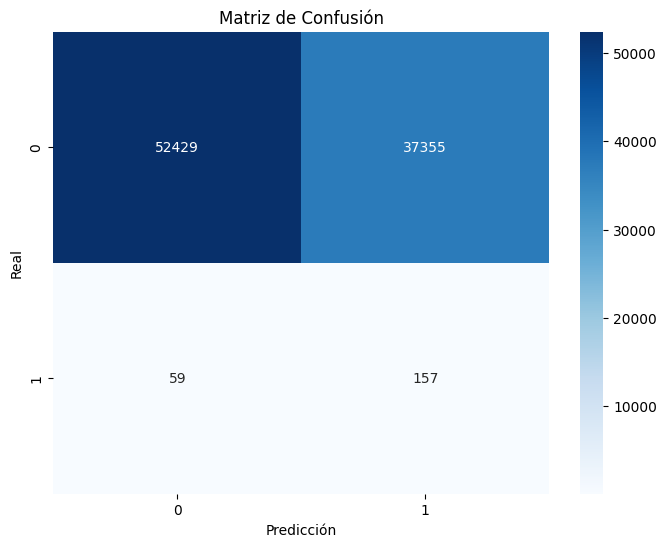

📌 Reporte de Clasificación:
               precision    recall  f1-score   support

           0       1.00      0.58      0.74     89784
           1       0.00      0.73      0.01       216

    accuracy                           0.58     90000
   macro avg       0.50      0.66      0.37     90000
weighted avg       1.00      0.58      0.74     90000



In [52]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Obtener predicciones
y_pred = loaded_model.predict(data_transform[expected_features])
y_test = data["target"].astype(int).to_list()
# Generar la matriz de confusión
cm = confusion_matrix(y_test, y_pred)
labels = sorted(set(y_test))  # Asegurar que los labels están en orden

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.show()

# Mostrar el reporte de clasificación
report = classification_report(y_test, y_pred, target_names=[str(label) for label in labels])
print("📌 Reporte de Clasificación:\n", report)
